In [1]:
import warnings
import numpy as np

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

from importlib import reload

import wandb

from context import omphalos

# Import Omphalos modules.
from omphalos import generate_inputs as gi
from omphalos import file_methods as fm
from omphalos import my_metrics as mm
from omphalos import omphalos_plotter as op
from omphalos import attributes as attr
from omphalos import labels as lbls
from omphalos import spatial_constructor

from matplotlib import pyplot as plt

%matplotlib inline
%precision 4

'%.4f'

In [3]:
train_set = fm.unpickle('data/1086_data.pkl')

for i in train_set:
    for condition in train_set[i].condition_blocks:
        train_set[i].condition_blocks[condition].concentrations = train_set[i].condition_blocks[condition].primary_species

attributes_df = attr.initial_conditions(train_set, primary_species=True)
labels_df = lbls.secondary_precip(train_set)

In [4]:
for i in train_set:
    for condition in train_set[i].condition_blocks:
        train_set[i].condition_blocks[condition].concentrations = train_set[i].condition_blocks[condition].primary_species

In [5]:
x = attributes_df.loc[:, ['SO4--','Ca++', 'Formaldehyde', 'CO2(aq)']].xs(1, level=1)
y = labels_df.xs(9, level=1)['Calcite'] + labels_df.xs(9, level=1)['Calcite44']

x = x.to_numpy() 
y = y.to_numpy().reshape(-1,1)
y = y * 1e4

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [7]:
dtest = xgb.DMatrix(x_test, label=y_test)

In [22]:
%%time
import xgboost as xgb

wandb.init(project='xgboost_1086')

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

evallist = [(dtest, 'eval'), (dtrain, 'train')]
param = {'max_depth': 6, 'eta': 0.0001, 'objective': 'reg:pseudohubererror', 'alpha': 1, 'lambda': 1}

results = {}

num_round = 1000000
bst = xgb.train(param, dtrain, num_round, evallist, evals_result=results, verbose_eval=False, callbacks=[wandb.xgboost.wandb_callback()])

eval-mphe,0.00756
train-mphe,0.00222
_runtime,2003
_timestamp,1613393997
_step,388766


eval-mphe,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train-mphe,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/usr/local/lib/python3.8/site-packages/xgboost/training.py:20: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


CPU times: user 6h 29min 39s, sys: 41min 39s, total: 7h 11min 18s
Wall time: 1h 57min 44s


In [24]:
bst.save_model('1086_model.json')

In [8]:
ypred = bst.predict(dtest)

from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, ypred))
rmse

0.12403483491326382

In [2]:
import xgboost as xgb
bst = xgb.Booster()
bst.load_model('1086_model.json')

## Plot sample

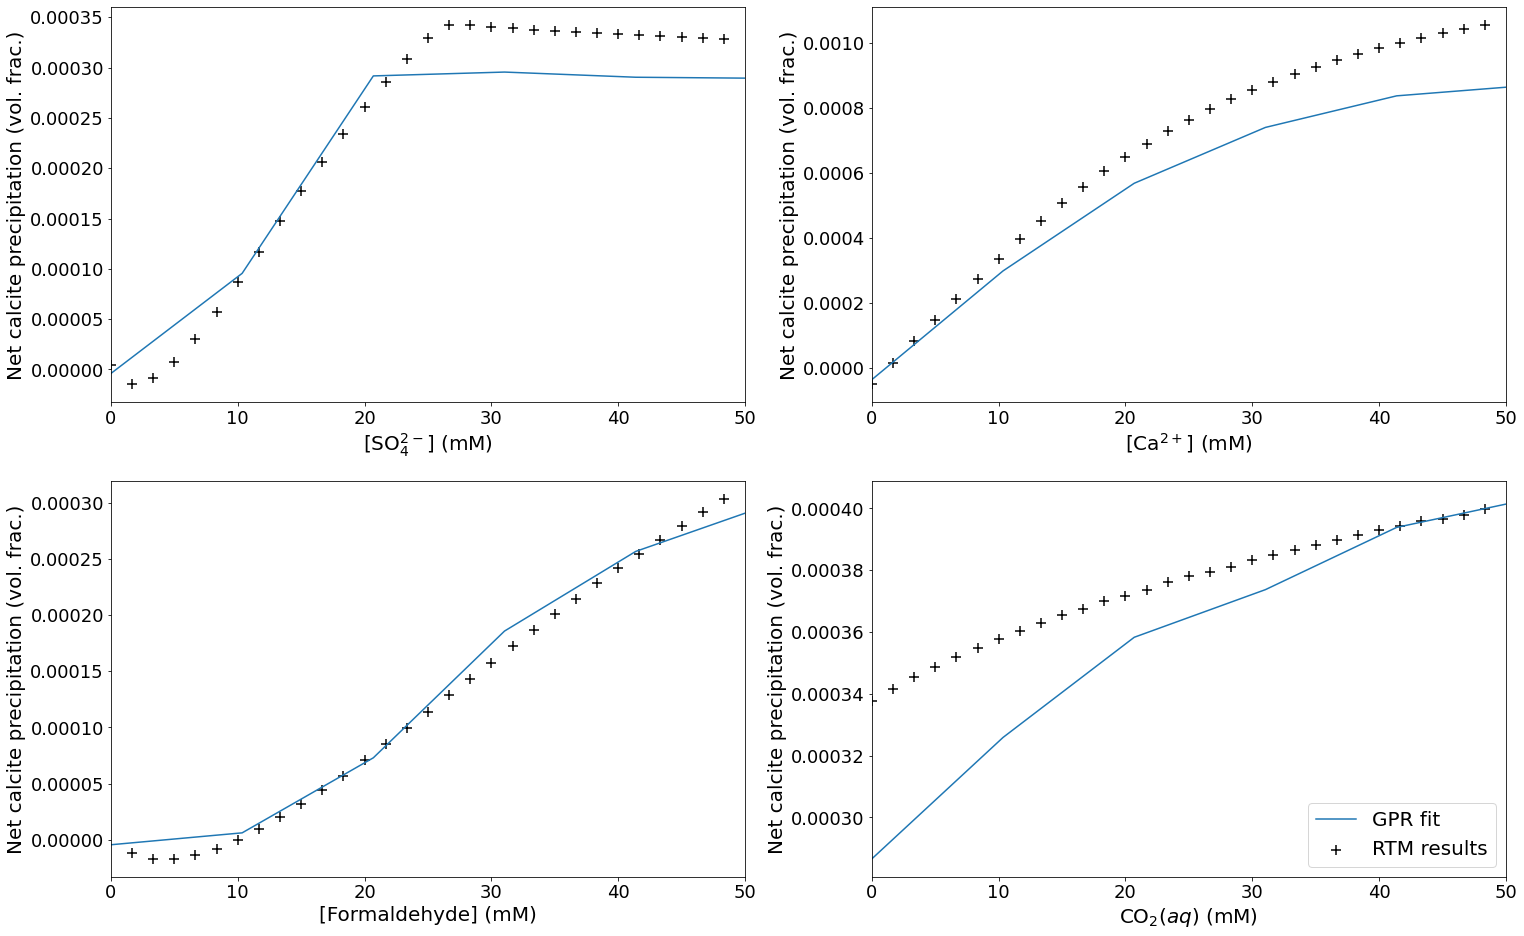

In [3]:
import gpflow_plotting as gpfp
from importlib import reload  
reload(gpfp)

# Make figure and layout.

fig = plt.figure(figsize=(25, 16))

#plt.subplots_adjust(wspace=1, hspace=0.25)

# Generate uneven subplots
sub1 = fig.add_subplot(2,2,1)
sub2 = fig.add_subplot(2,2,2)
sub3 = fig.add_subplot(2,2,3)
sub4 = fig.add_subplot(2,2,4)


axis_list = [sub1, sub2, sub3, sub4]

species_list = ['SO4--','Ca++', 'Formaldehyde', 'CO2(aq)']
axis_labels = ['[SO$_4^{2-}$] (mM)','[Ca$^{2+}$] (mM)', '[Formaldehyde] (mM)', 'CO$_2(aq)$ (mM)']

samples = 30
dims = 4
plot_vars = np.arange(4)

predict_range = (0,300e-3)

for plot_var, x_label, species, ax in zip(plot_vars, axis_labels, species_list, axis_list):
    defaults = np.ones((samples, dims))
    # Default (Druhan 2014)
    defaults[:,0] = 26.79609e-03
    defaults[:,1] = 1.01838314236E-02
    defaults[:,2] = 0.55e-01
    defaults[:,3] = 2.00e-03
    path = 'data/1086_sweeps/{}.pkl'.format(species)

    defaults[:,plot_var] = np.linspace(predict_range[0], predict_range[1], len(defaults[:, plot_var]))
    
    ypred = bst.predict(xgb.DMatrix(defaults))


    sweep_x, sweep_y = gpfp.get_sweep(path, species, 'amendment', ('Calcite', 'Calcite44'))
    ax.plot(defaults[:, plot_var]*1000, ypred *1e-4, label='GBTree fit')
    
    ax.set_xlabel(x_label, fontsize=20)
    ax.set_ylabel('Net calcite precipitation (vol. frac.)', fontsize=20)
    ax.tick_params('both', labelsize=18)

    ax.set_xlim(0,50)
    
    ax.scatter(sweep_x * 1000, sweep_y, c="k", marker='+', s=100,label='RTM results')
sub4.legend(('GPR fit', 'RTM results'), fontsize=20,loc="lower right", ncol=1)

In [4]:
fig.savefig('/Users/angus/Dropbox/ompahlos_paper/figures/1086_fit.png', dpi=300)